In [1]:
from fleck import generate_spots, Star
import sys
sys.path.insert(0, "../")

from michael import janet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

Hi there. Welcome to the good place.


Let's set up the fleck parameters

TESS noise is roughly 800-1800 ppm

In [2]:
np.random.seed(802)
N = 250
spot_contrast = np.random.uniform(0.5, 1., size=N)
rotation_period = np.random.uniform(1.5, 27., size=N)
u_ld = [0.5, 0.2]

spot_radius = np.random.uniform(0.05, 0.15, size=N)
min_latitude = np.random.uniform(30, 60, size=N)
max_latitude = np.random.uniform(61, 85, size=N)

t = np.arange(0, 27., 0.02)
yerr = np.random.normal(800, 1500, size=N)*1e-6

n_phases = len(t)
n_inclinations = 1
n_spots = np.random.uniform(10, 30, size=N).astype(int)

In [3]:
np.random.seed(802)

sim = np.zeros((N, len(t)))
obs = np.zeros((N, len(t)))

for idx in range(N):
    lons, lats, radii, inc_stellar = generate_spots(min_latitude[idx], max_latitude[idx],
                                                   spot_radius[idx], n_spots[idx],
                                                   n_inclinations=n_inclinations)
    star = Star(spot_contrast = spot_contrast[idx], n_phases=n_phases, 
                u_ld = u_ld, rotation_period = rotation_period[idx])
    lc = star.light_curve(lons, lats, radii, inc_stellar, times=t)
    
    lc -= np.mean(lc)
    lc += 1.
    
    sim[idx, :] = lc.flatten()
    obs[idx, :] = lc.flatten() + yerr[idx] * np.random.randn(len(t))
               
plt.show()

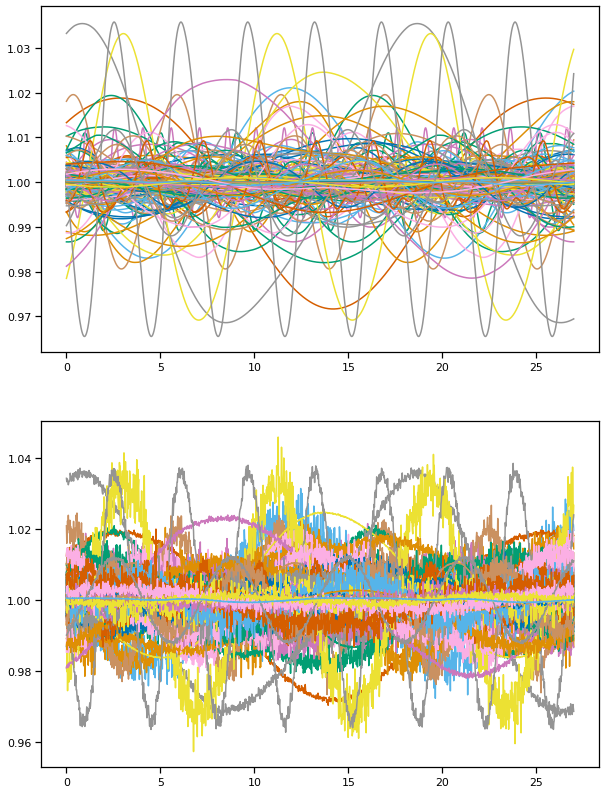

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10, 14))
ax[0].plot(t, sim.T)
ax[1].plot(t, obs.T)
plt.show()

Now let's obtain rotation for every target

In [5]:
df = pd.DataFrame(index = range(N), columns=['P', 'Perr', 'Pflag'])

for idx in range(N):
    j = janet(gaiaid = f'Test unit {idx}',
         output_path = "/Users/oliver hall/Research/michael/Examples/simtests",
         verbose=False)
    
    j.flux_override(t, obs[idx])
    j.get_rotation(period_range = (rotation_period.min(), rotation_period.max()))
    j.validate_rotation()
    
    df.loc[idx, 'P']= j.results.loc['best', 'overall']
    df.loc[idx, 'Perr']= j.results.loc['best', 'e_overall']
    df.loc[idx, 'Pflag']= j.results.loc['best', 'f_overall']
df['Ptrue'] = rotation_period
df.to_csv('simulated_periods.csv')

/Users/Anaconda/anaconda3/lib/python3.8/site-packages/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")
../michael/validate.py:127: UserWarning: No estimates could agree. Please inspect the results carefully yourself.
  warnings.warn("No estimates could agree. Please inspect the results carefully yourself.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")
../michael/validate.py:127: UserWarning: No estimates could agree. Please inspect the results carefully yourself.
  warnings.warn("No estimates could agree. Please inspect the results carefully yourself.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

../michael/methods.py:373: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [6]:
j.results

,SLS,e_SLS,f_SLS,SW,e_SW,CACF,e_CACF,ACF,s_SLS,s_SW,s_CACF,overall,e_overall,f_overall
all,15.069419,1.506942,0.0,15.668173,2.471715,14.82737,1.226264,14.58,NaN,NaN,NaN,NaN,NaN,NaN
best,15.069419,1.506942,0.0,15.668173,2.471715,14.82737,1.226264,NaN,all,all,all,14.82737,1.226264,4.0


../michael/plotting.py:437: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{j.output_path}/{j.gaiaid}/output.pdf', rasterized=True)


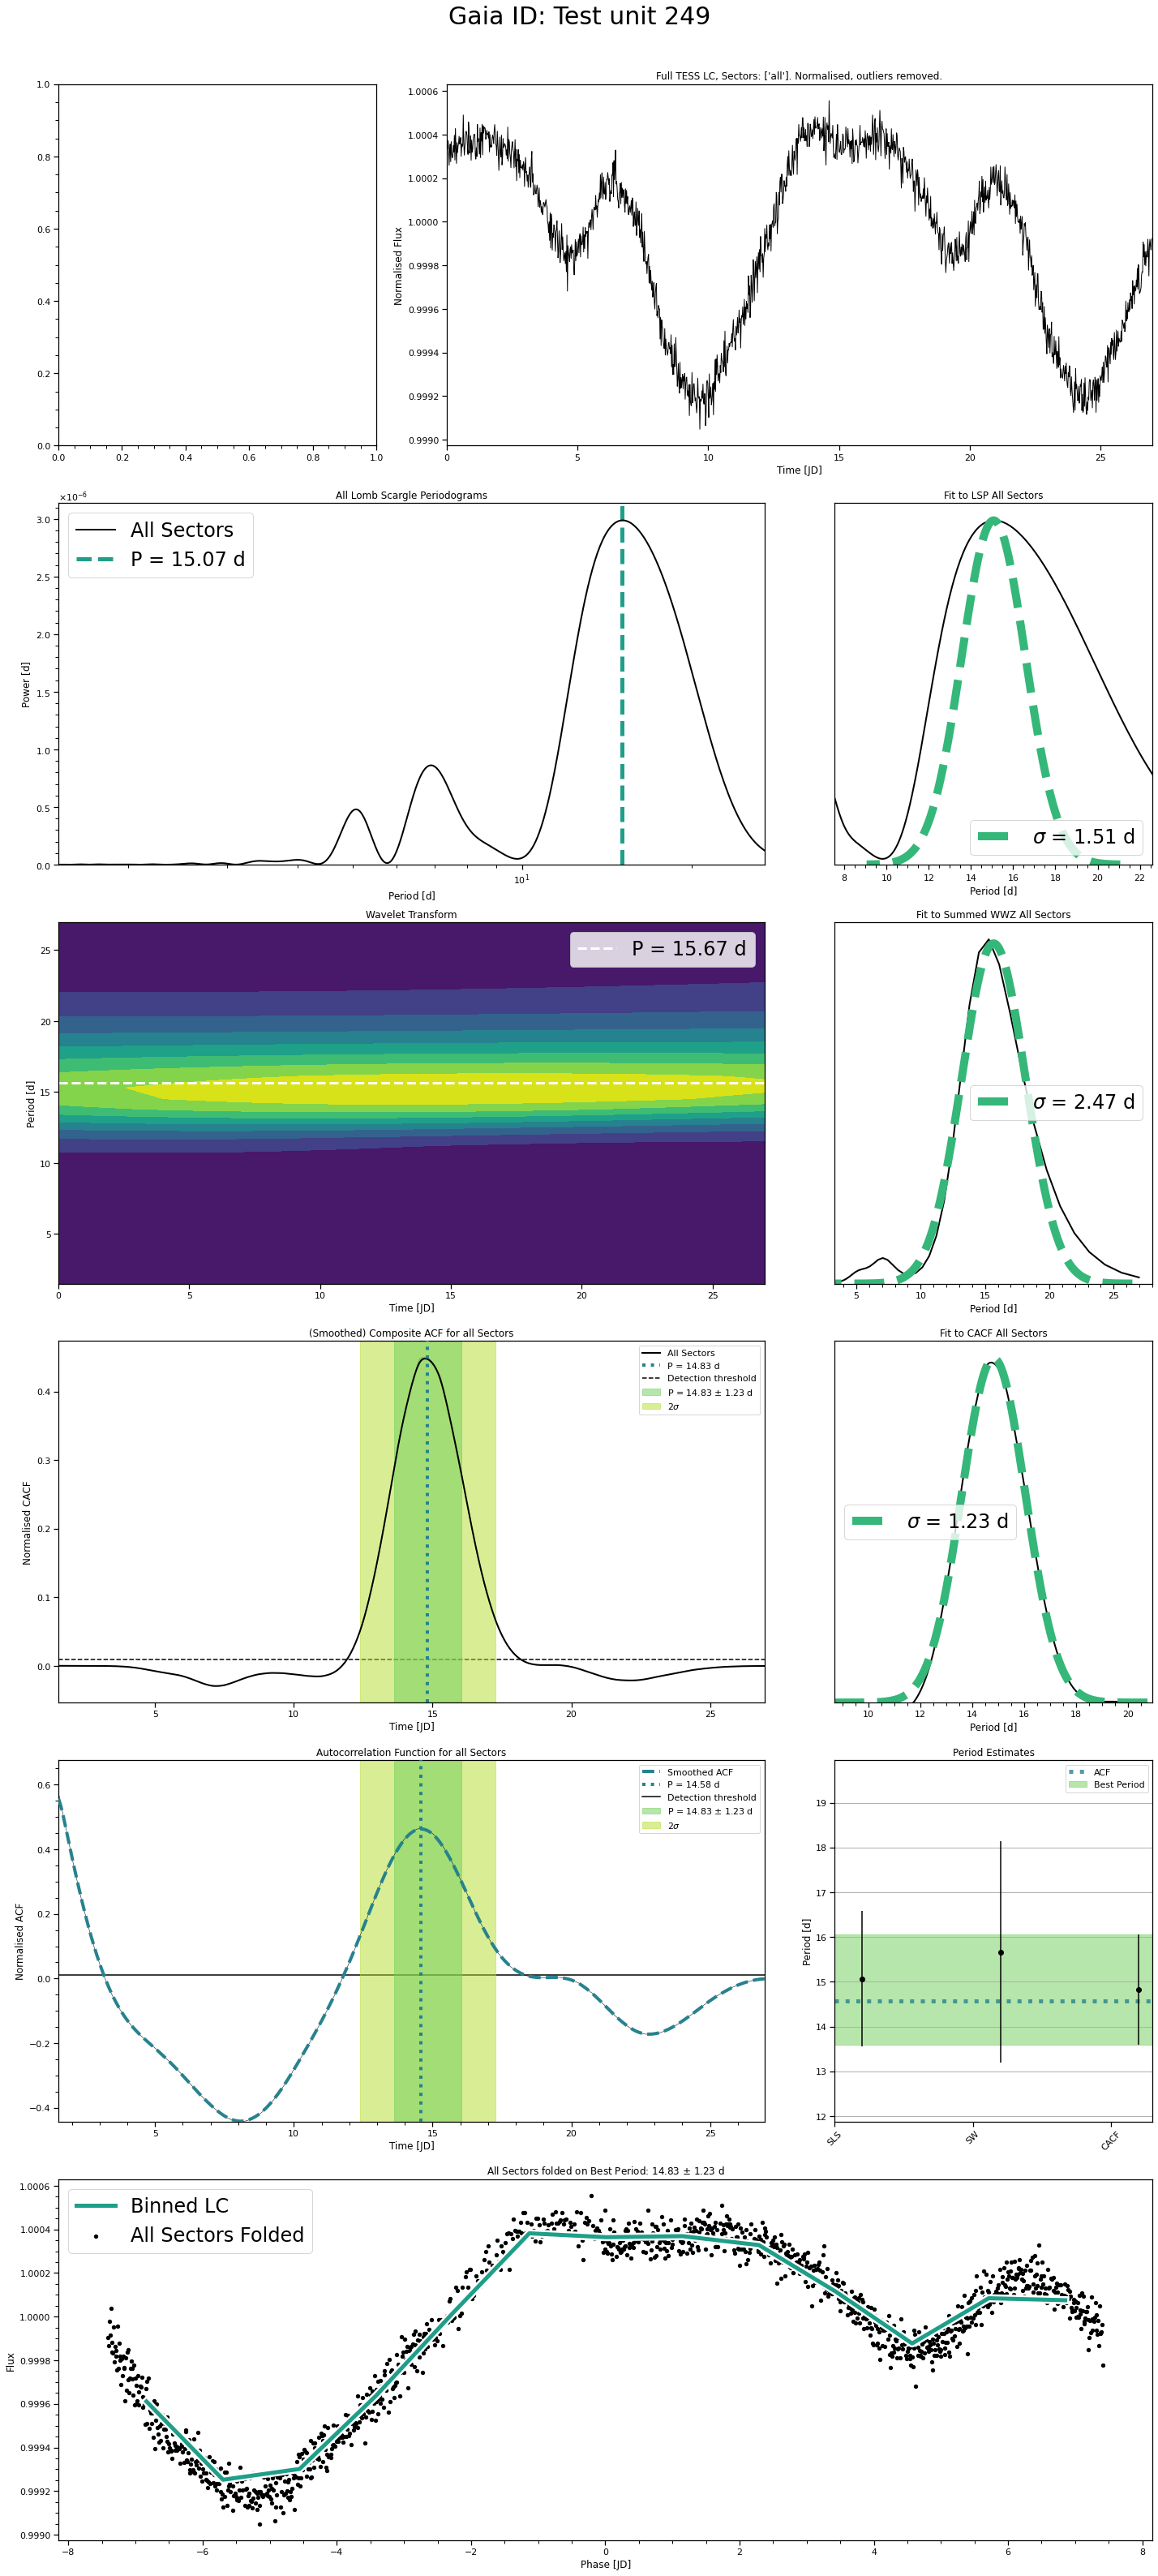

In [7]:
j.view()

In [8]:
df['Ptrue'] = rotation_period
df.to_csv('simulated_periods.csv')

In [9]:
df

,P,Perr,Pflag,Ptrue
0,5.94634,0.443186,4.0,5.948987
1,15.069419,1.506942,129.0,15.474052
2,1.652331,0.036168,1.0,1.651623
3,15.338452,1.692414,4.0,16.023198
4,NaN,NaN,164.0,23.385543
...,...,...,...,...
245,26.969728,2.696973,145.0,26.213986
246,23.486331,1.755732,4.0,25.188250
247,6.164305,0.216071,2.0,6.190319
248,13.762632,1.376263,1.0,13.792549


### Comparing outcomes

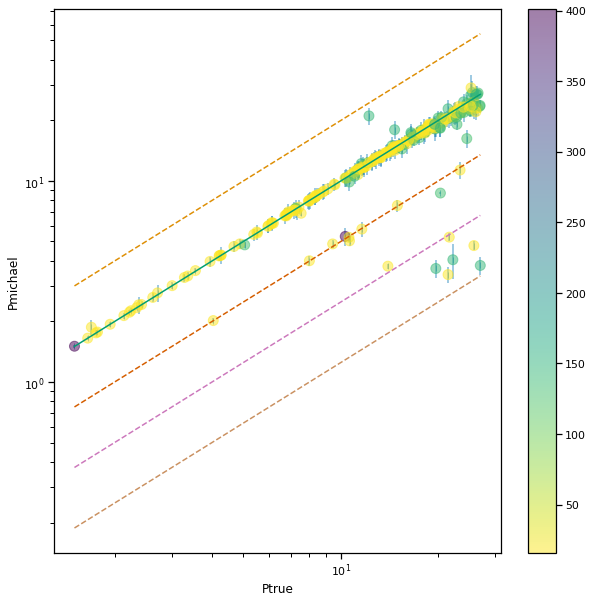

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
c = ax.scatter(df.Ptrue, df.P, c = df.Pflag, s=100, zorder=2, alpha=.5, vmin=16, 
               cmap='viridis_r')
ax.errorbar(df.Ptrue, df.P, yerr=df.Perr, fmt='|', zorder=1, alpha=.5)

lintru = np.linspace(df.Ptrue.min(), df.Ptrue.max(), 100)
ax.plot(lintru, 2*lintru, ls='--')
ax.plot(lintru, lintru, ls='-')
ax.plot(lintru, 0.5*lintru, ls='--')
ax.plot(lintru, 0.25*lintru, ls='--')
ax.plot(lintru, 0.125*lintru, ls='--')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Ptrue')
ax.set_ylabel('Pmichael')
fig.colorbar(c)

## Let's investigate some of the stars that are being excluded

In [11]:
out = df[np.abs(df.P - df.Ptrue) > df.Perr]


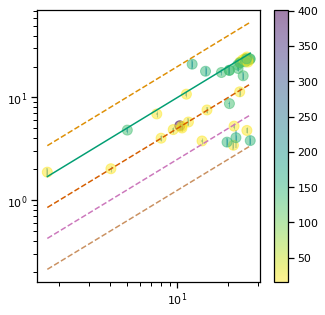

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
c = ax.scatter(out.Ptrue, out.P, c = out.Pflag, s=100, zorder=2, alpha=.5, vmin=16, 
               cmap='viridis_r')
ax.errorbar(out.Ptrue, out.P, yerr=out.Perr, fmt='|', zorder=1, alpha=.5)

lintru = np.linspace(out.Ptrue.min(), out.Ptrue.max(), 100)
ax.plot(lintru, 2*lintru, ls='--')
ax.plot(lintru, lintru, ls='-')
ax.plot(lintru, 0.5*lintru, ls='--')
ax.plot(lintru, 0.25*lintru, ls='--')
ax.plot(lintru, 0.125*lintru, ls='--')

ax.set_yscale('log')
ax.set_xscale('log')

fig.colorbar(c)

### The three targets above the line

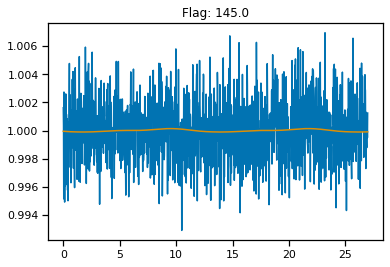

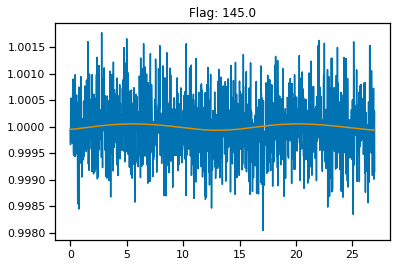

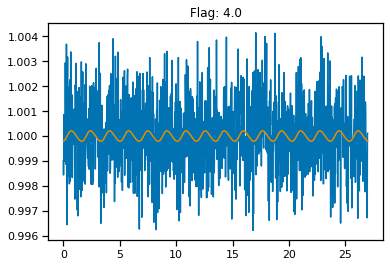

In [13]:
hi = out[(out.P - out.Ptrue) > out.Perr]
for idx in hi.index:
    plt.title(f'Flag: {hi.loc[idx, "Pflag"]}')
    plt.plot(t, obs[idx])
    plt.plot(t, sim[idx])
    plt.show()

**Conclusion**: Small amplitudes at large uncertainties, unmeasurable. Appropriate flags, behaving as intended.

### Targets on the 2:1 line

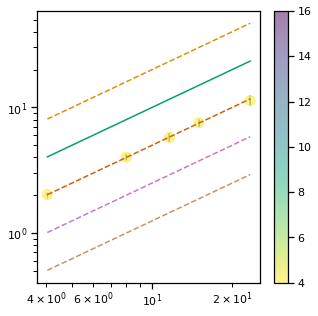

In [14]:
hi = out[np.abs(out.P-0.5*out.Ptrue) < out.Perr]
hi = hi[hi.Pflag < 16]
fig, ax = plt.subplots(figsize=(5, 5))
c = ax.scatter(hi.Ptrue, hi.P, c = hi.Pflag, s=100, zorder=2, alpha=.5, vmin=16, 
               cmap='viridis_r')
ax.errorbar(hi.Ptrue, hi.P, yerr=hi.Perr, fmt='|', zorder=1, alpha=.5)

lintru = np.linspace(hi.Ptrue.min(), hi.Ptrue.max(), 100)
ax.plot(lintru, 2*lintru, ls='--')
ax.plot(lintru, lintru, ls='-')
ax.plot(lintru, 0.5*lintru, ls='--')
ax.plot(lintru, 0.25*lintru, ls='--')
ax.plot(lintru, 0.125*lintru, ls='--')

ax.set_yscale('log')
ax.set_xscale('log')

fig.colorbar(c)

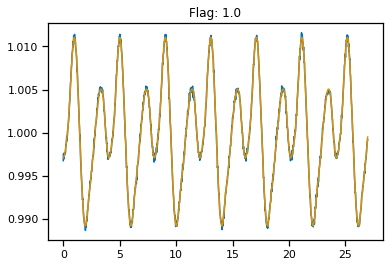

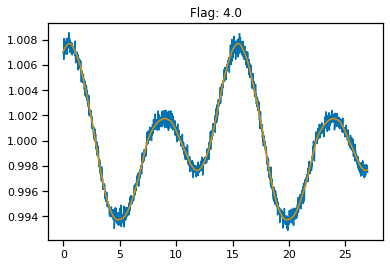

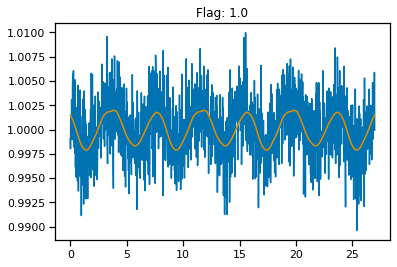

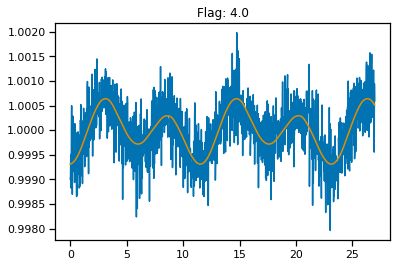

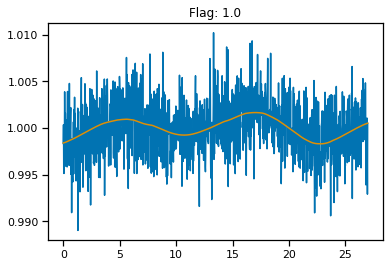

In [15]:
for idx in hi.index:
    plt.title(f'Flag: {hi.loc[idx, "Pflag"]}')
    plt.plot(t, obs[idx])
    plt.plot(t, sim[idx])
    plt.show()

**Conclusions**: There are 2 stars which would benefit from a compound ACF treatment. The remaining 3 stars appear to serendipitously have spots on opposite sides of the stellar sphere, giving rise to faux-harmonic signals.

## The remaining stars < 2:1 line

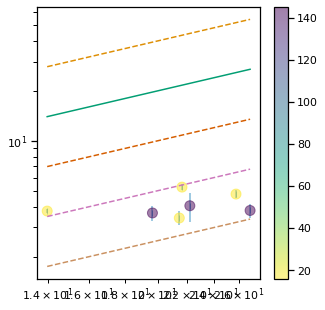

In [16]:
hi = out[out.P < 0.3*out.Ptrue]


fig, ax = plt.subplots(figsize=(5, 5))
c = ax.scatter(hi.Ptrue, hi.P, c = hi.Pflag, s=100, zorder=2, alpha=.5, vmin=16, 
               cmap='viridis_r')
ax.errorbar(hi.Ptrue, hi.P, yerr=hi.Perr, fmt='|', zorder=1, alpha=.5)

lintru = np.linspace(hi.Ptrue.min(), hi.Ptrue.max(), 100)
ax.plot(lintru, 2*lintru, ls='--')
ax.plot(lintru, lintru, ls='-')
ax.plot(lintru, 0.5*lintru, ls='--')
ax.plot(lintru, 0.25*lintru, ls='--')
ax.plot(lintru, 0.125*lintru, ls='--')

ax.set_yscale('log')
ax.set_xscale('log')

fig.colorbar(c)

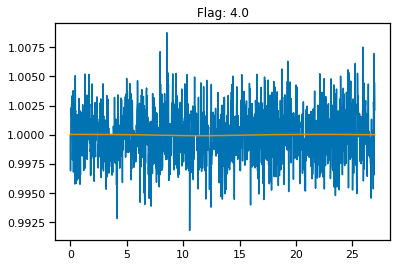

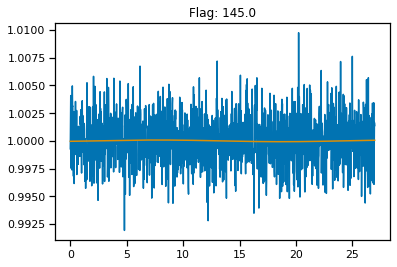

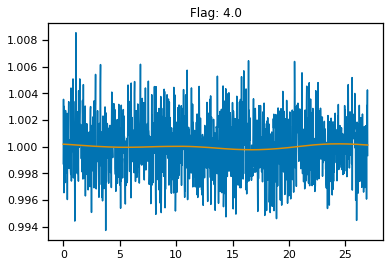

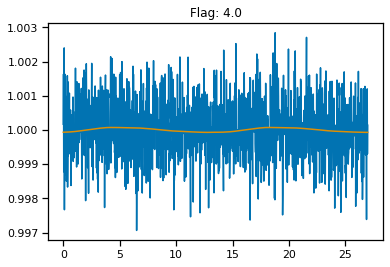

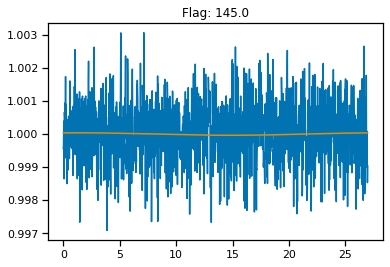

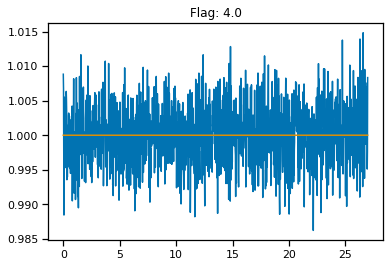

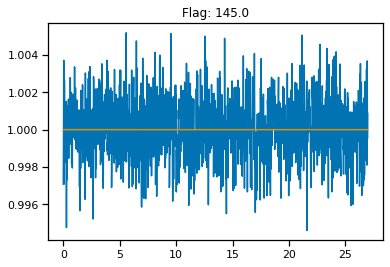

In [17]:
for idx in hi.index:
    plt.title(f'Flag: {hi.loc[idx, "Pflag"]}')
    plt.plot(t, obs[idx])
    plt.plot(t, sim[idx])
    plt.show()

## Finally, flagged stars within the 1:1 scope

In [18]:
j.decode(126)


------ Decoding Overall Period Flag 126 ------
64: No ACF period could be reliably measured (indicating low power or long periods).
32: None of the 3 estimates agreed with one another to within 1 sigma. The CACF estimate is assumed to be the best in this case.
16: Only 2 of the 3 estimates of rotation agreed with one another to within 1 sigma.
8: Best rotation is from the Gaussian Process (GP) method.
4: Best rotation is from the Composite Autocorrelation Function (CACF) method.
2: Best rotation is from the Simple Wavelet (SW) method.

No other flags raised. 



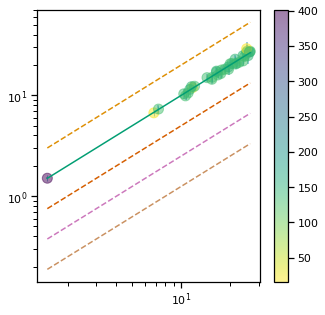

In [19]:
hi = df[(np.abs(df.P - df.Ptrue) < df.Perr) & (df.Pflag > 16)]


fig, ax = plt.subplots(figsize=(5, 5))
c = ax.scatter(hi.Ptrue, hi.P, c = hi.Pflag, s=100, zorder=2, alpha=.5, vmin=16, 
               cmap='viridis_r')
ax.errorbar(hi.Ptrue, hi.P, yerr=hi.Perr, fmt='|', zorder=1, alpha=.5)

lintru = np.linspace(hi.Ptrue.min(), hi.Ptrue.max(), 100)
ax.plot(lintru, 2*lintru, ls='--')
ax.plot(lintru, lintru, ls='-')
ax.plot(lintru, 0.5*lintru, ls='--')
ax.plot(lintru, 0.25*lintru, ls='--')
ax.plot(lintru, 0.125*lintru, ls='--')

ax.set_yscale('log')
ax.set_xscale('log')

fig.colorbar(c)

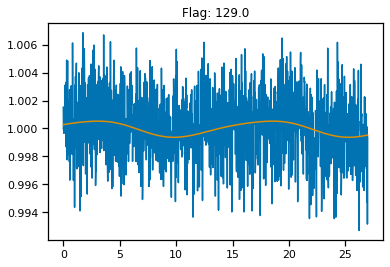

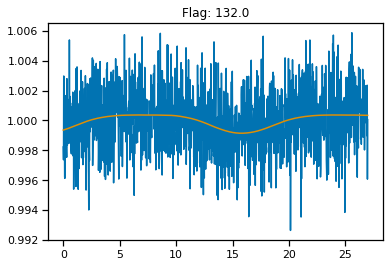

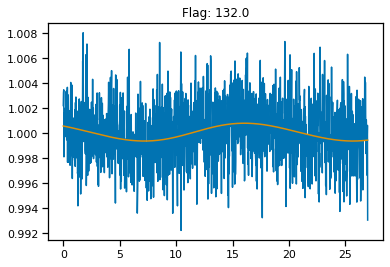

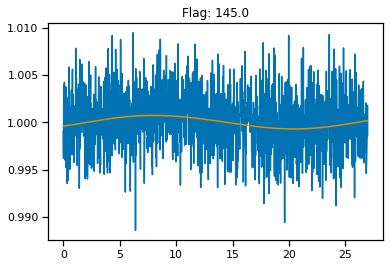

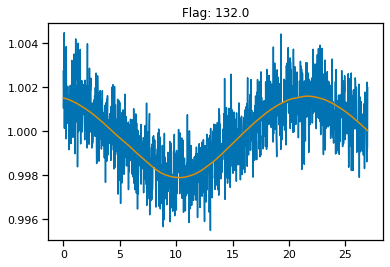

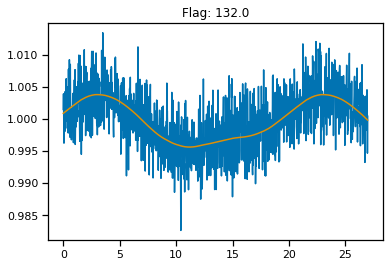

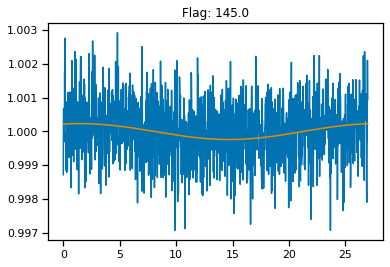

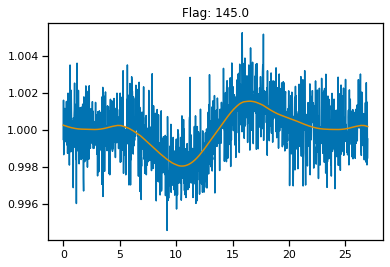

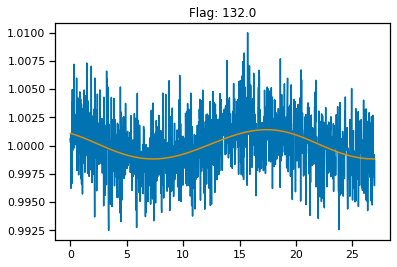

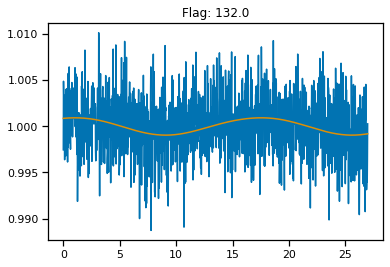

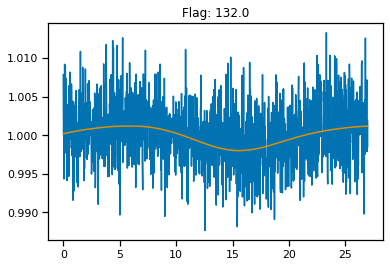

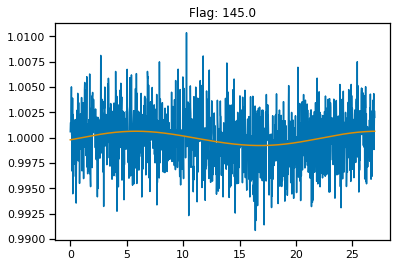

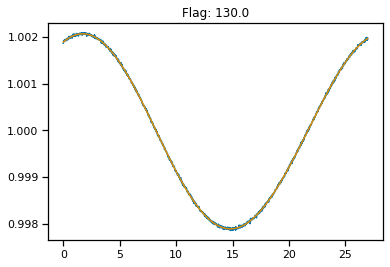

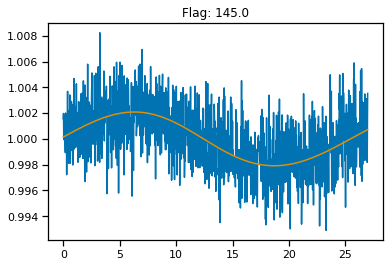

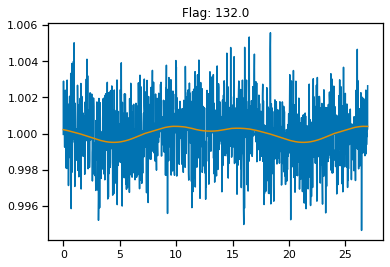

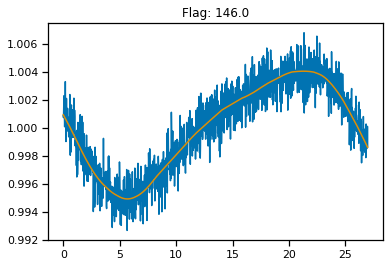

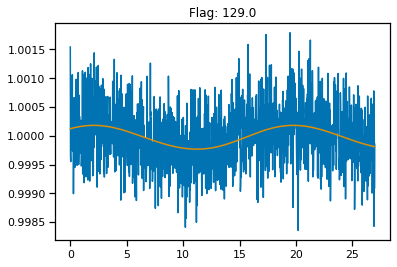

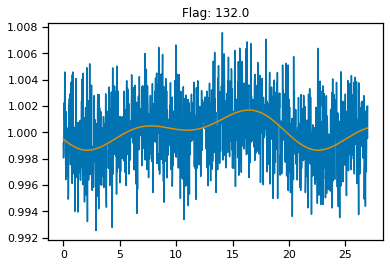

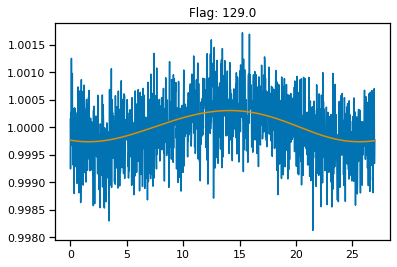

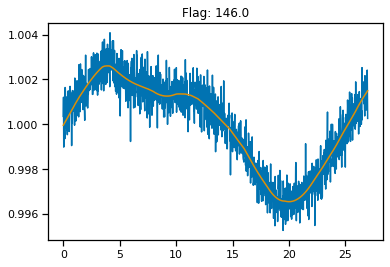

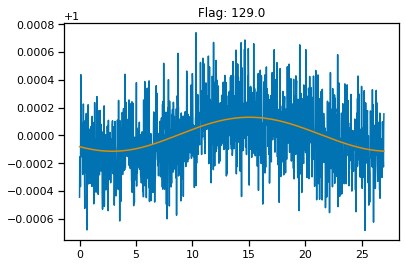

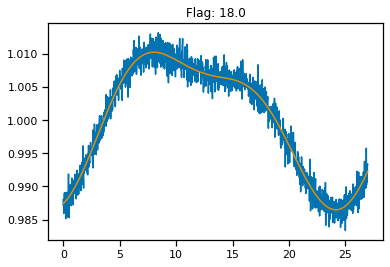

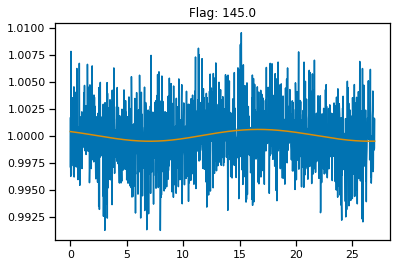

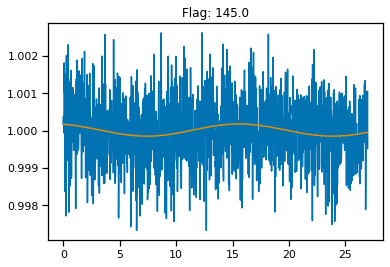

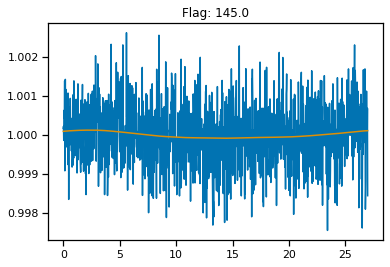

In [20]:
hi = df[(np.abs(df.P - df.Ptrue) < df.Perr) & (df.Pflag > 16) & (df.P > 15)]
for idx in hi.index:
    plt.title(f'Flag: {hi.loc[idx, "Pflag"]}')
    plt.plot(t, obs[idx])
    plt.plot(t, sim[idx])
    plt.show()

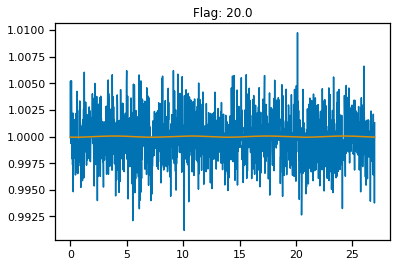

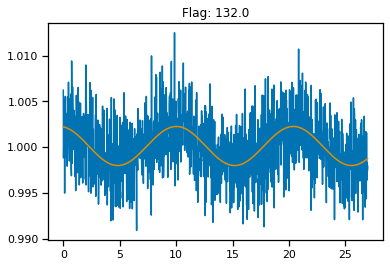

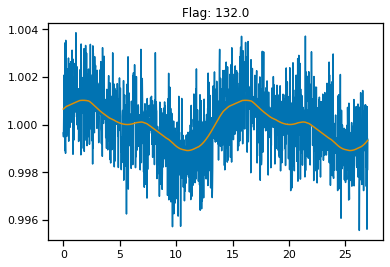

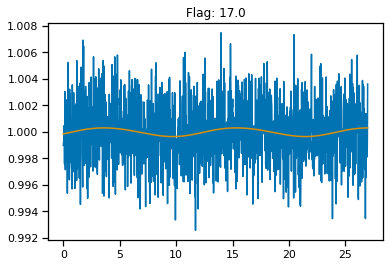

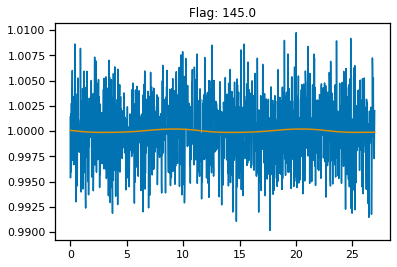

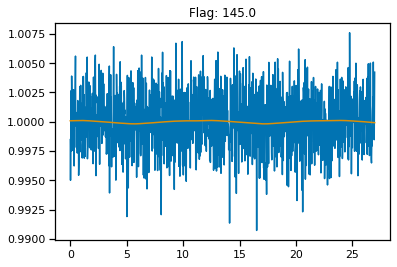

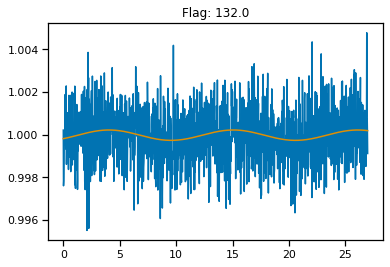

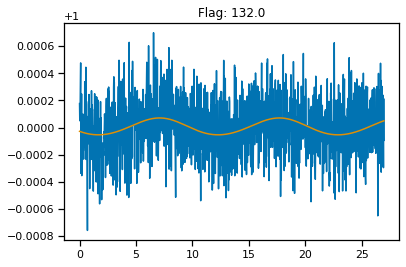

In [21]:
hi = df[(np.abs(df.P - df.Ptrue) < df.Perr) & (df.Pflag > 16) & (df.P < 15) & (df.P > 4) & (df.Pflag != 129)]
for idx in hi.index:
    plt.title(f'Flag: {hi.loc[idx, "Pflag"]}')
    plt.plot(t, obs[idx])
    plt.plot(t, sim[idx])
    plt.show()

In [22]:
hi

,P,Perr,Pflag,Ptrue
34,6.704468,0.133427,20.0,6.787805
51,10.36114,1.078875,132.0,10.362887
71,14.983336,1.484907,132.0,14.401009
76,11.936042,1.193604,17.0,11.740360
85,11.430359,1.143036,145.0,11.279215
111,12.206041,1.220604,145.0,11.564324
198,10.552116,0.887196,132.0,11.026502
242,9.880118,0.95531,132.0,10.623812


In [23]:
    idx = 197
    j = janet(gaiaid = f'Test unit {idx}',
         output_path = "/Users/oliver hall/Research/michael/Examples/simtests",
         verbose=False)
    
    j.flux_override(t, obs[idx])
    j.get_rotation(period_range = (rotation_period.min(), rotation_period.max()))
    j.validate_rotation()

  0%|          | 0/54 [00:00<?, ?it/s]

../michael/plotting.py:437: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{j.output_path}/{j.gaiaid}/output.pdf', rasterized=True)


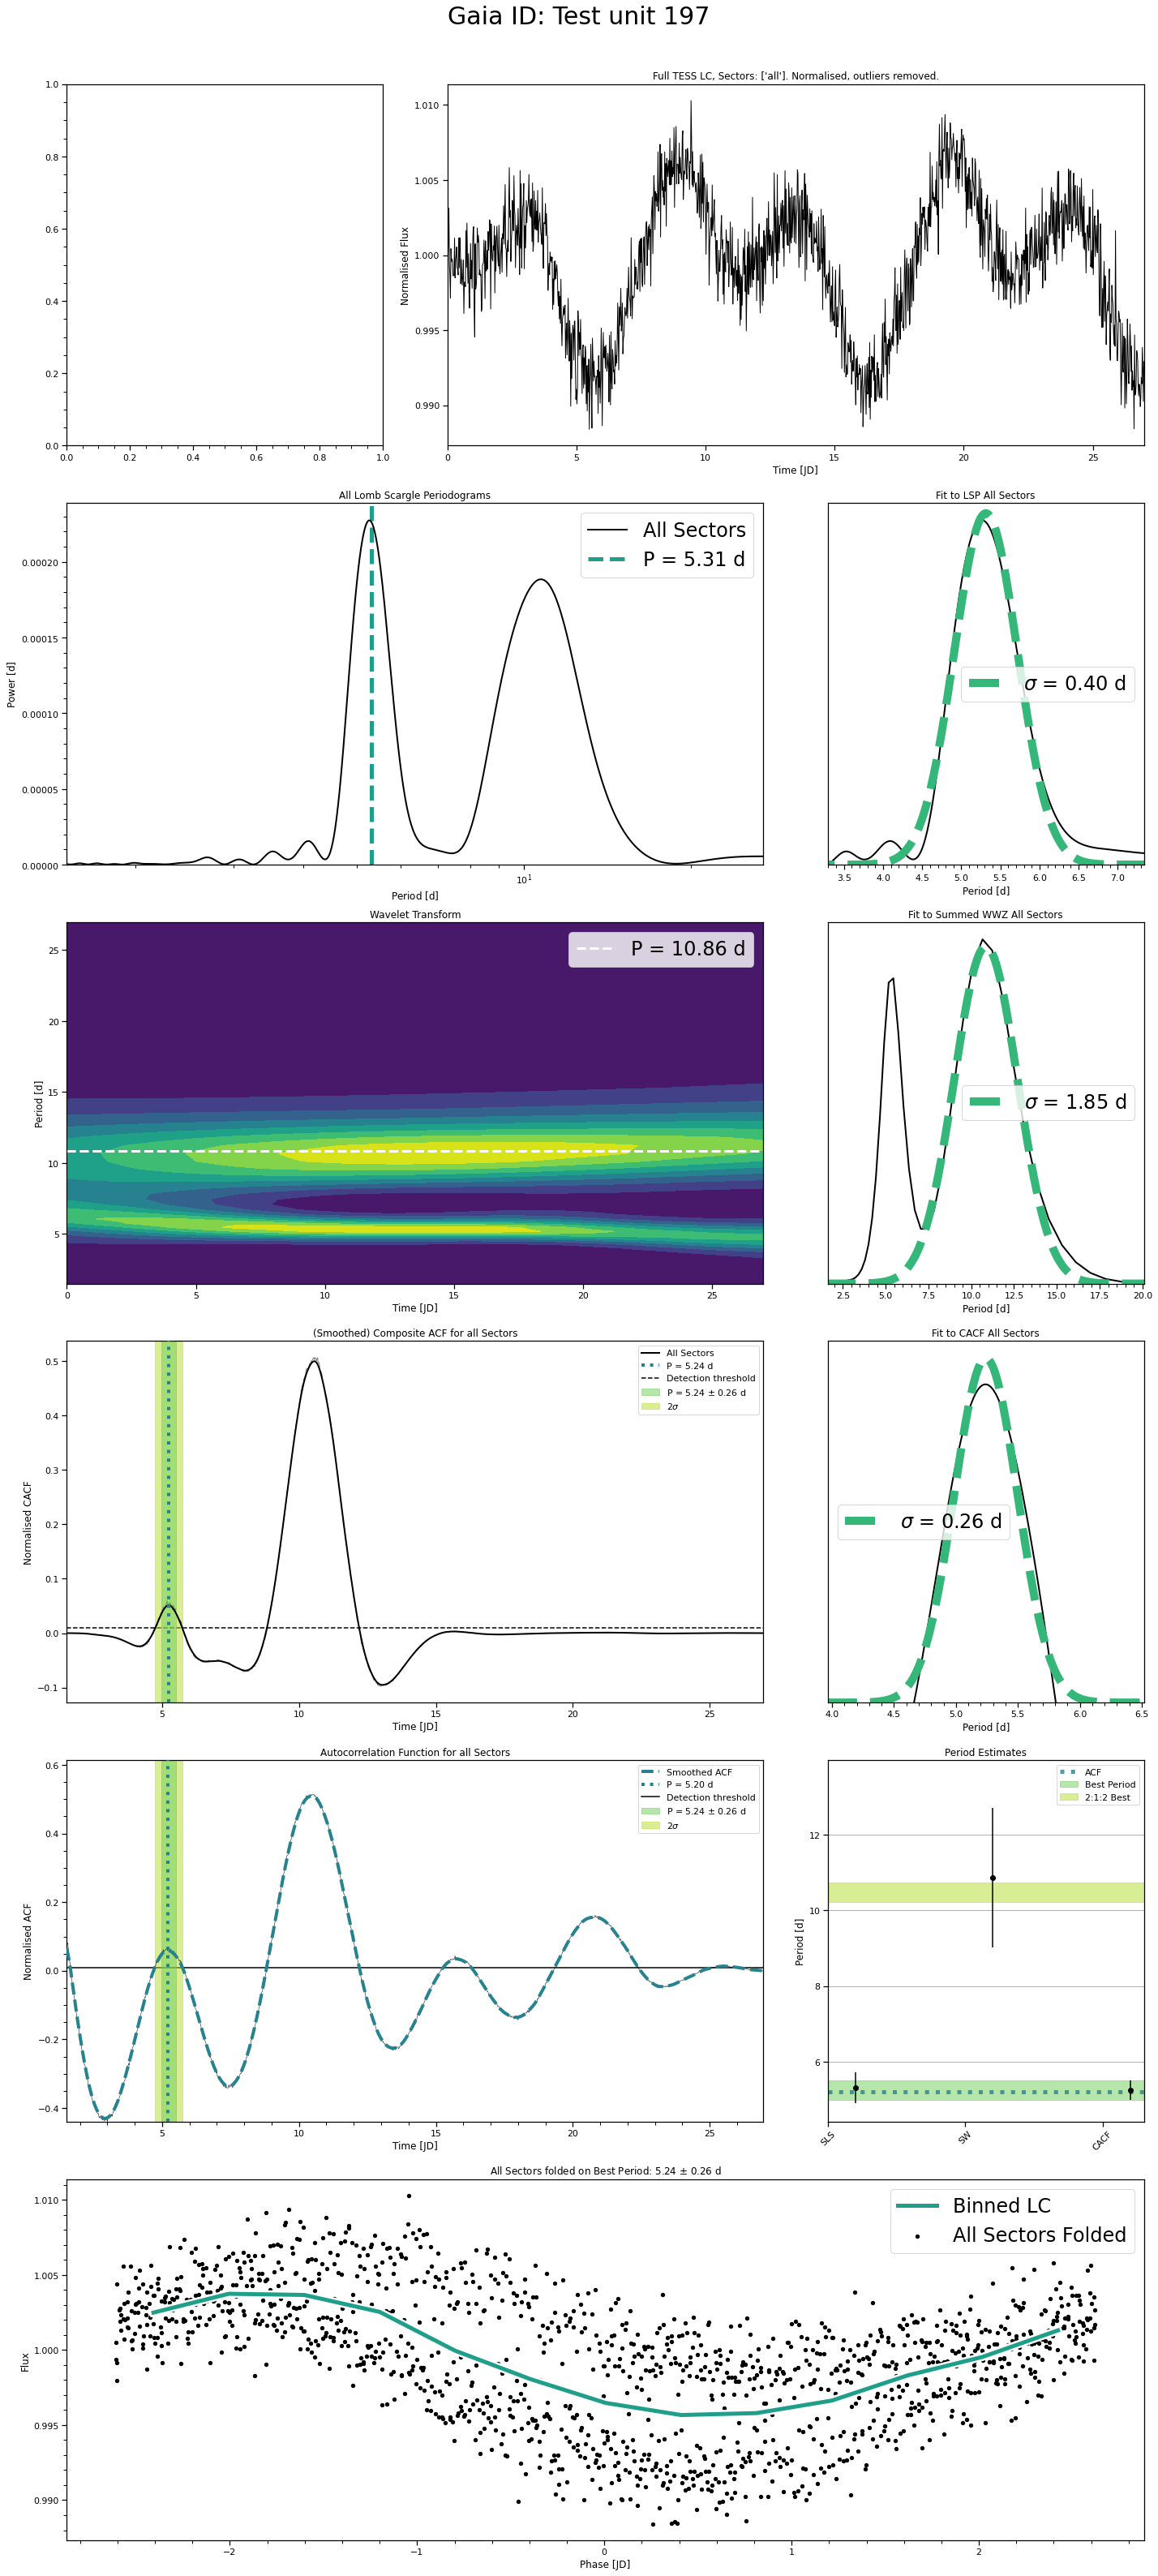

In [24]:
j.view();